In [ ]:
!pip install --upgrade gensim
!pip install matplotlib scikit-learn

from gensim.models import word2vec
import logging

import numpy as np

In [ ]:
import os
import re
from collections import defaultdict

# Known IUPAC ambiguity codes to remove
AMBIGUOUS_CODES = set("NYMRSWKBHDV")

# Valid nucleotide bases
VALID_BASES = set("ATCG")

def clean_line(line, file_path):
    """
    Removes known ambiguous IUPAC codes. Raises an error if unknown characters are found.
    """
    line = line.strip().upper()
    cleaned = []

    ambiguous_found = False
    for char in line:
        if char in VALID_BASES:
            cleaned.append(char)
        elif char in AMBIGUOUS_CODES:
            ambiguous_found = True  # remove, but record
        elif char == '':
            continue
        else:
            raise ValueError(f"Invalid character '{char}' found in file {file_path}: {repr(line)}")

    return ''.join(cleaned) + '\n', ambiguous_found

def merge_folders_to_file(folders, output_file):
    ambiguous_counts = defaultdict(int)  # folder_name -> count of files with ambiguous letters

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for folder in folders:
            for root, _, files in os.walk("../" + folder):
                for file in sorted(files):
                    outfile.write(f'>{folder}/{file}\n')
                    file_path = os.path.join(root, file)
                    file_had_ambiguous = False

                    with open(file_path, 'r', encoding='utf-8') as infile:
                        for line in infile:
                            if line.startswith('>'):
                                continue  # Skip headers
                            cleaned_line, had_ambiguous = clean_line(line, file_path)
                            if had_ambiguous:
                                file_had_ambiguous = True
                            if cleaned_line.strip():  # skip if line is empty
                                outfile.write(cleaned_line)

                    if file_had_ambiguous:
                        ambiguous_counts[folder] += 1
                outfile.write('\n')

    # Summary
    print("Ambiguity Removal Report:")
    for folder, count in ambiguous_counts.items():
        print(f"- {count} file(s) in '{folder}' had IUPAC ambiguity codes removed.")
    if not ambiguous_counts:
        print("No ambiguous bases found in any files.")

if __name__ == "__main__":
    folders_to_merge = ['Bacillaceae', 'Bacillus', 'Bacillus cereus group']  # replace with your folder paths
    output_filename = 'seqdump.txt'
    merge_folders_to_file(folders_to_merge, output_filename)


Ambiguity Removal Report:
- 72 file(s) in 'Bacillaceae' had IUPAC ambiguity codes removed.
- 35 file(s) in 'Bacillus' had IUPAC ambiguity codes removed.
- 5 file(s) in 'Bacillus cereus group' had IUPAC ambiguity codes removed.


In [ ]:
def parse_fasta_file(filepath):
    names = []
    dnas = []

    with open(filepath, "r", encoding="utf-8") as f:
        name = None
        seq = []

        for line in f:
            line = line.strip()

            if line.startswith('>'):
                if name is not None:
                    dnas.append(''.join(seq))
                name = line[1:]
                names.append(name)
                seq = []
            else:
                seq.append(line)

        # Handle last sequence
        if name is not None and seq:
            dnas.append(''.join(seq))

    return names, dnas

names, dnas = parse_fasta_file("seqdump.txt")
print(f"Parsed {len(names)} sequences.")

Parsed 299 sequences.


In [5]:
KMER = 4
assert len(names) == len(dnas)

def kmers(sequence, k=KMER):
    length = len(sequence) - k + 1
    for i in range(length):
        yield sequence[i:i+k]

with open("5.txt", "w", encoding="utf-8") as f:
    for seq in dnas:
        f.write(" ".join(kmers(seq)))


In [8]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)  
sentences = word2vec.Text8Corpus('5.txt')  
model = word2vec.Word2Vec(sentences, sg=1,  window=24,  min_count=1,  negative=5, sample=0.001, hs=0, workers=20,epochs=1,vector_size=100,seed=0)  
model.save('5_txt_word2vec.model') 

2025-05-18 18:37:33,317 : INFO : collecting all words and their counts
2025-05-18 18:37:33,319 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-05-18 18:37:39,592 : INFO : PROGRESS: at sentence #10000, processed 100000000 words, keeping 283 word types
2025-05-18 18:37:45,907 : INFO : PROGRESS: at sentence #20000, processed 200000000 words, keeping 308 word types
2025-05-18 18:37:52,237 : INFO : PROGRESS: at sentence #30000, processed 300000000 words, keeping 333 word types
2025-05-18 18:37:58,400 : INFO : PROGRESS: at sentence #40000, processed 400000000 words, keeping 357 word types
2025-05-18 18:38:04,516 : INFO : PROGRESS: at sentence #50000, processed 500000000 words, keeping 379 word types
2025-05-18 18:38:10,604 : INFO : PROGRESS: at sentence #60000, processed 600000000 words, keeping 404 word types
2025-05-18 18:38:16,717 : INFO : PROGRESS: at sentence #70000, processed 700000000 words, keeping 430 word types
2025-05-18 18:38:22,764 : INFO : PROGRE

In [9]:
model = word2vec.Word2Vec.load('5_txt_word2vec.model')
import numpy as np

KMER = 4
dim = model.vector_size
model_keys = set(model.wv.key_to_index)

v = []
vc = []

for seq in dnas:
    mean = np.zeros(dim, dtype=np.float64)
    M2 = np.zeros(dim, dtype=np.float64)
    n = 0

    for i in range(len(seq) - KMER + 1):
        kmer = seq[i:i + KMER]
        if kmer in model_keys:
            vec = model.wv[kmer]
            n += 1
            delta = vec - mean
            mean += delta / n
            delta2 = vec - mean
            M2 += delta * delta2

    if n > 0:
        var = M2 / n
    else:
        mean = np.zeros(dim)
        var = np.zeros(dim)

    v.append(mean)
    vc.append(var)

vv = [np.hstack((mean, var)) for mean, var in zip(v, vc)]

nn = len(dnas)
# Compute pairwise Euclidean distance matrix efficiently
# vv_matrix shape: (nn, 2 * vector_dim)
vv_matrix = np.vstack(vv)
from scipy.spatial.distance import pdist, squareform

dist_matrix = squareform(pdist(vv_matrix, metric='euclidean'))

# Now write output file in similar format but cleaner:

with open("results.txt", "w", encoding="utf-8") as f:
    for i, name in enumerate(names):
        f.write(f"[{i+1}] # {name}\n")

    f.write("[ ")
    for i in range(1, nn+1):
        f.write(f"{i} ")
    f.write("]\n")

    f.write("[ 1 ]\n")
    for i in range(1, nn):
        f.write(f"[ {i+1} ] ")
        # distances for row i, only lower triangle elements (j < i)
        for j in range(i):
            f.write(f"{dist_matrix[i,j]:0.10f} ")
        f.write("\n")

2025-05-18 19:02:54,533 : INFO : loading Word2Vec object from 5_txt_word2vec.model
2025-05-18 19:02:54,537 : INFO : loading wv recursively from 5_txt_word2vec.model.wv.* with mmap=None
2025-05-18 19:02:54,537 : INFO : setting ignored attribute cum_table to None
2025-05-18 19:02:54,540 : INFO : Word2Vec lifecycle event {'fname': '5_txt_word2vec.model', 'datetime': '2025-05-18T19:02:54.540205', 'gensim': '4.3.3', 'python': '3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]', 'platform': 'Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'event': 'loaded'}


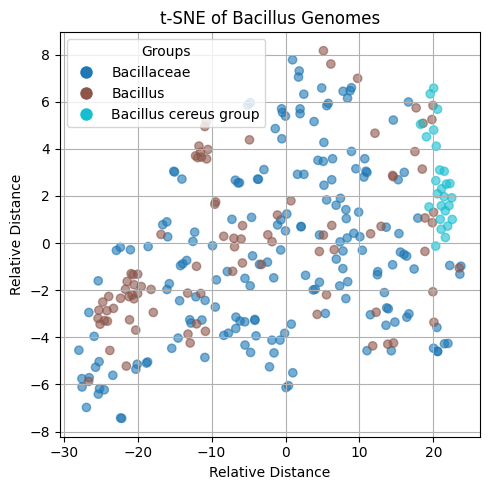

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import pickle

# Use the valid vectors
vectors = np.array(vv)
group_labels = [s.split('/')[0] for s in names]

np.save('vectors.npy', vectors)
with open('group_labels.pkl', 'wb') as f:
    pickle.dump(group_labels, f)

### Uncomment to load
# with open('group_labels.pkl', 'rb') as f:
#     group_labels = pickle.load(f)
# vectors = np.load('vectors.npy')

# Make sure group_labels matches
assert len(group_labels) == len(vectors), "Mismatch between vectors and group labels"

# Encode group names to integers for color mapping
label_encoder = LabelEncoder()
group_codes = label_encoder.fit_transform(group_labels)
group_names = label_encoder.classes_

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
vectors_2d = tsne.fit_transform(vectors)

# Plot
plt.figure(figsize=(5, 5))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=group_codes, cmap='tab10', alpha=0.6)
plt.title('t-SNE of Bacillus Genomes')
plt.xlabel('Relative Distance')
plt.ylabel('Relative Distance')
# plt.xlim(-100, 100)
# plt.ylim(-100, 100)

# Custom legend
handles = [
    plt.Line2D([], [], marker='o', color='w', label=group,
               markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
    for i, group in enumerate(group_names)
]
plt.legend(handles=handles, title='Groups')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot.png")
